In [71]:
# Dependencies
from bs4 import BeautifulSoup
import requests
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from datetime import datetime
import gmaps
from scipy.stats import linregress

In [2]:
# Initialize PyMongo to work with MongoDBs
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [3]:
# Define database and collection
db = client.stayathome_db
collection = db.state_quarantine

In [4]:
print(db.state_orders.find_one())
db.state_orders.insert_one({'key': 'value'})

{'_id': ObjectId('5e7fb2005ce6cf72a85ffc22'), 'key': 'value'}


In [5]:
# URL of page to be scraped
url = 'https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html'

# Retrieve page with the requests module
response = requests.get(url)

# Create BeautifulSoup object; parse with 'lxml'
soup = BeautifulSoup(response.text, 'html.parser')

In [6]:
# print(soup.find_all('div', class_='state-wrap'))

In [7]:
ca_measures_state = soup.find('div', id='item-CA').find('h3').text
ca_measures_order = soup.find('div', id='item-CA').find('p', class_='l-order').text

print(ca_measures_state)
print(ca_measures_order)

California About 39.6 million people
Stay at home, effective March 19


In [8]:
# soup.find_all('div', class_="state-wrap")
# soup.find_all('div', class_="state-wrap")

In [9]:
# # Retrieve the parent divs for all states
sah_measures = soup.find_all('div', class_="state-wrap")


# loop over results to get article data
for each_measure in sah_measures:
    # scrape the article header     
    state = each_measure.find('h3').text
    
    # scrape the article subheader
    sah_order = each_measure.find('p', class_='l-order').text
    
    # scrape the datetime
    effective_date = each_measure.find('span', class_='l-date').text
    
    # print article data
    print('-----------------')
    print(state)
    print(sah_order)
    print(effective_date)

    # Dictionary to be inserted into MongoDB
    state_measures = {
        'state': state,
        'sah_order': sah_order,
        'effective_date': effective_date,
    }
    
    

    # Insert dictionary into MongoDB as a document
    collection.insert_one(state_measures)

-----------------
Alabama
Shelter in place, effective March 24 at 12 p.m.
, effective March 24 at 12 p.m.
-----------------
Alaska About 737,000 people
Stay at home, effective March 28 at 5 p.m.
, effective March 28 at 5 p.m.
-----------------
Arizona About 7.2 million people
Stay at home, effective March 31 at 5 p.m.
, effective March 31 at 5 p.m.
-----------------
California About 39.6 million people
Stay at home, effective March 19
, effective March 19
-----------------
Colorado About 5.7 million people
Stay at home, effective March 26 at 6 a.m.
, effective March 26 at 6 a.m.
-----------------
Connecticut About 3.6 million people
Stay at home, effective March 23 at 8 p.m.
, effective March 23 at 8 p.m.
-----------------
Delaware About 973,000 people
Shelter in place, effective March 24 at 8 a.m.
, effective March 24 at 8 a.m.
-----------------
District of Columbia About 702,000 people
Stay at home, effective April 1 at 12:01 a.m.
, effective April 1 at 12:01 a.m.
-----------------
F

In [10]:
top_six = ['New York','New Jersey','California','Washington','Michigan','Florida']
state_measures

{'state': 'Wyoming',
 'sah_order': 'Stay at home, effective March 28',
 'effective_date': ', effective March 28',
 '_id': ObjectId('5e82b9f0ffbb84fb4678249c')}

In [11]:
# state_measures_df = DataFrame(list(state_measures.items()), columns = ['state','sah_order','effective_date'])
state_measures_df = DataFrame(list(db.state_quarantine.find({})))

In [12]:
state_measures_df = state_measures_df[['state','sah_order']]
state_measures_df

,state,sah_order
0,Missouri,"Stay at home, effective March 24 at 12:01 a.m."
1,Montana About 1.1 million people,"Stay at home, effective March 28 at 12:01 a.m."
2,New Hampshire About 1.4 million people,"Stay at home, effective March 27 at 11:59 p.m."
3,New Jersey About 8.9 million people,"Stay at home, effective March 21 at 9 p.m."
4,New Mexico About 2.1 million people,"Stay at home, effective March 24 at 8 a.m."
...,...,...
181,Virginia About 8.5 million people,"Stay at home, effective March 30"
182,Washington About 7.5 million people,"Stay at home, effective March 23"
183,West Virginia About 1.8 million people,"Stay at home, effective March 24 at 8 p.m."
184,Wisconsin About 5.8 million people,"Stay at home, effective March 25 at 8 a.m."


In [13]:
state_measures_df[['order','date']] = state_measures_df.sah_order.str.split(', effective ', expand=True)

state_measures_df.head(2)

,state,sah_order,order,date
0,Missouri,"Stay at home, effective March 24 at 12:01 a.m.",Stay at home,March 24 at 12:01 a.m.
1,Montana About 1.1 million people,"Stay at home, effective March 28 at 12:01 a.m.",Stay at home,March 28 at 12:01 a.m.


In [14]:
state_measures_df[['State','Population']] = state_measures_df.state.str.split(' About ', expand=True)

state_measures_df.head(2)

,state,sah_order,order,date,State,Population
0,Missouri,"Stay at home, effective March 24 at 12:01 a.m.",Stay at home,March 24 at 12:01 a.m.,Missouri,None
1,Montana About 1.1 million people,"Stay at home, effective March 28 at 12:01 a.m.",Stay at home,March 28 at 12:01 a.m.,Montana,1.1 million people


In [15]:
top_six = ['New York','New Jersey','California','Washington','Michigan','Florida']
state_measures_df = state_measures_df[['State','order','date']]
state_measures_df.head(3)


,State,order,date
0,Missouri,Stay at home,March 24 at 12:01 a.m.
1,Montana,Stay at home,March 28 at 12:01 a.m.
2,New Hampshire,Stay at home,March 27 at 11:59 p.m.


In [16]:
state_measures_df.iloc[2,0]

'New Hampshire'

In [17]:
top_six_df = state_measures_df[state_measures_df['State'].isin(top_six)]
top_six_df1=top_six_df.iloc[:6]
top_six_df1

,State,order,date
3,New Jersey,Stay at home,March 21 at 9 p.m.
5,New York,Stay at home,March 22 at 8 p.m.
17,Washington,Stay at home,March 23
22,California,Stay at home,March 19
26,Florida,Stay at home,March 24 at 12:01 a.m.
37,Michigan,Stay at home,March 24 at 12:01 a.m.


In [18]:
# db.users.remove({})
# collection.insert_one(state_measures)

collection.db.state_quarantine.remove({})

C:\Users\positivelyalli\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.
  after removing the cwd from sys.path.


{'n': 0, 'ok': 1.0}

In [19]:
top_six_df = top_six_df1
top_six_df

,State,order,date
3,New Jersey,Stay at home,March 21 at 9 p.m.
5,New York,Stay at home,March 22 at 8 p.m.
17,Washington,Stay at home,March 23
22,California,Stay at home,March 19
26,Florida,Stay at home,March 24 at 12:01 a.m.
37,Michigan,Stay at home,March 24 at 12:01 a.m.


In [20]:
top_six_df.set_index('State', inplace=True)
top_six_df

,order,date
State,,
New Jersey,Stay at home,March 21 at 9 p.m.
New York,Stay at home,March 22 at 8 p.m.
Washington,Stay at home,March 23
California,Stay at home,March 19
Florida,Stay at home,March 24 at 12:01 a.m.
Michigan,Stay at home,March 24 at 12:01 a.m.


In [21]:
top_six_df.to_csv('top_six.csv')

In [22]:
top_six_df[['date','time']] = top_six_df.date.str.split(' at ', expand=True)
top_six_df


,order,date,time
State,,,
New Jersey,Stay at home,March 21,9 p.m.
New York,Stay at home,March 22,8 p.m.
Washington,Stay at home,March 23,None
California,Stay at home,March 19,None
Florida,Stay at home,March 24,12:01 a.m.
Michigan,Stay at home,March 24,12:01 a.m.


In [23]:
top_six_df = top_six_df[['order','date']]
top_six_df


,order,date
State,,
New Jersey,Stay at home,March 21
New York,Stay at home,March 22
Washington,Stay at home,March 23
California,Stay at home,March 19
Florida,Stay at home,March 24
Michigan,Stay at home,March 24


In [24]:
datetime.strptime('March 21 2020', '%B %d %Y')

datetime.datetime(2020, 3, 21, 0, 0)

In [25]:
top_six_df['date'] = top_six_df['date'] + ' 2020'

C:\Users\positivelyalli\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
top_six_df['date'] = pd.to_datetime(top_six_df.date, format='%B %d %Y')


C:\Users\positivelyalli\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
top_six_df.to_csv('top_six.csv')

Plot size bubbles for deaths by state

In [28]:
top_states_data = pd.read_csv('covid_top_states.csv')
top_states_data


,State,Cases,Deaths
0,New York,59513,965
1,New Jersey,13386,161
2,California,5735,124
3,Michigan,4635,112
4,Washington,4319,191
5,Massachusetts,4257,44
6,Florida,4238,55
7,Illinois,3558,50
8,Louisiana,3540,152
9,Pennsylvania,3408,38


In [50]:
deathpercase = (top_states_data['Deaths']/top_states_data['Cases'])
deathpercase

0    0.016215
1    0.012027
2    0.021622
3    0.024164
4    0.044223
5    0.010336
6    0.012978
7    0.014053
8    0.042938
9    0.011150
dtype: float64

In [56]:
top_states_data2 = top_states_data

top_states_data2['Mortality Rate'] =deathpercase

# .format("{:.2%}")

top_states_styled = top_states_data2.style.format({ 'Mortality Rate': '{:.2%}'})
top_states_styled

,State,Cases,Deaths,Mortality Rate
0,New York,59513,965,1.62%
1,New Jersey,13386,161,1.20%
2,California,5735,124,2.16%
3,Michigan,4635,112,2.42%
4,Washington,4319,191,4.42%
5,Massachusetts,4257,44,1.03%
6,Florida,4238,55,1.30%
7,Illinois,3558,50,1.41%
8,Louisiana,3540,152,4.29%
9,Pennsylvania,3408,38,1.12%


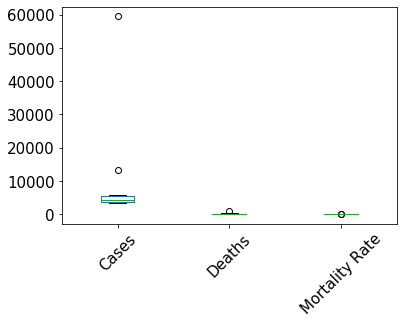

In [57]:
top_states_data2.boxplot(grid=False, rot=45, fontsize=15)

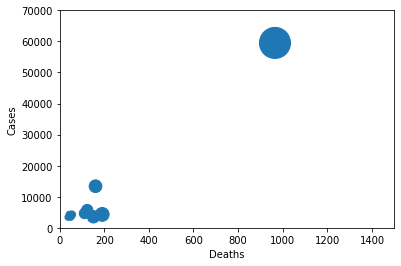

In [31]:
top_states_data.plot.scatter(x='Deaths', 
                             y='Cases', 
                             s=top_states_data['Deaths'],
                             xlim = (0,1500),
                             ylim = (0,70000),
                             
                            );


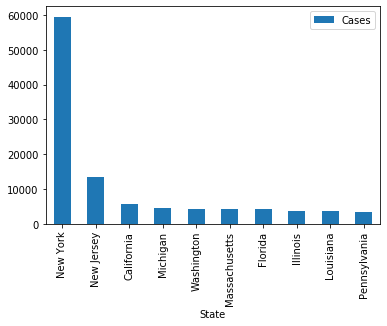

In [32]:

# top_states_data[['Cases', 'Deaths']].plot(kind='bar', stacked=True)

top_states_data.plot(kind='bar', x = 'State', y = 'Cases')



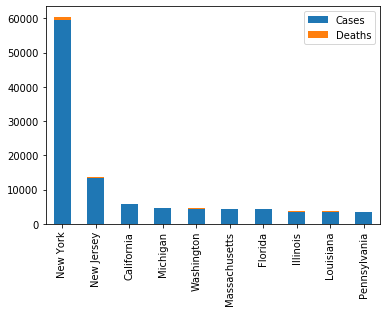

In [90]:
y_pos = np.arange(len(top_states_data['Cases']))
tick_labels = top_states_data['State']

top_states_data[['Cases', 'Deaths']].plot(kind='bar', stacked=True)

# Create names
plt.xticks(y_pos, tick_labels)

plt.savefig('stacked_bar.png')


In [ ]:
# cases = (20, 35, 30, 35, 27)
# ind = np.arange(N) 
# width = 0.35       
# plt.bar(ind, men_means, width, label='Men')
# plt.bar(ind + width, women_means, width,
#     label='Women')

# plt.ylabel('Scores')
# plt.title('Scores by group and gender')

# plt.xticks(ind + width / 2, ('G1', 'G2', 'G3', 'G4', 'G5'))
# plt.legend(loc='best')
# plt.show()

cases = top_states_data['Cases']
deaths = top_states_data['Deaths']
index = top_states_data['State']

df = pd.DataFrame({'cases': cases,
                  'deaths': deaths}, index=index)
y_pos = np.arange(len(top_states_data['Cases']))
tick_labels = top_states_data['State']

ax = top_states_data.plot.bar(rot=0, subplots = True, figsize=(15,5))

# Create names
plt.xticks(y_pos, tick_labels)


plt.savefig('subplot_bar.png')


In [91]:
top_states_df = top_states_data[top_states_data['State'].isin(top_six)]

top_states_df['Mortality Rate'] = top_states_df['Mortality Rate']*100

top_states_df


C:\Users\positivelyalli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,State,Cases,Deaths,Mortality Rate
0,New York,59513,965,1.621494
1,New Jersey,13386,161,1.202749
2,California,5735,124,2.162162
3,Michigan,4635,112,2.416397
4,Washington,4319,191,4.422320
6,Florida,4238,55,1.297782


In [92]:
# read census data csv
pop_df = pd.read_csv('out.csv')

pop_df

,Name,Population,Percent_Seniors
0,California,39557045.0,14.326998
1,Florida,21299325.0,20.464423
2,New York,19542209.0,16.436550
3,New Jersey,8908520.0,16.145095
4,Michigan,9995915.0,17.211561
5,Washington,7535591.0,15.446526


In [93]:
top_states_pop = pd.merge(top_states_df, pop_df, how='inner', left_on='State', right_on='Name')
top_states_pop = top_states_pop[['State', 'Cases', 'Deaths', 'Population', 'Mortality Rate', 'Percent_Seniors']]
top_states_pop

,State,Cases,Deaths,Population,Mortality Rate,Percent_Seniors
0,New York,59513,965,19542209.0,1.621494,16.436550
1,New Jersey,13386,161,8908520.0,1.202749,16.145095
2,California,5735,124,39557045.0,2.162162,14.326998
3,Michigan,4635,112,9995915.0,2.416397,17.211561
4,Washington,4319,191,7535591.0,4.422320,15.446526
5,Florida,4238,55,21299325.0,1.297782,20.464423


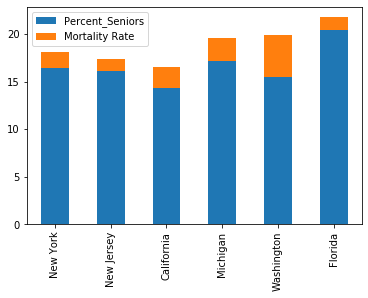

In [100]:
y_pos = np.arange(len(top_states_pop['Mortality Rate']))
tick_labels = top_states_pop['State']

top_states_pop[['Percent_Seniors', 'Mortality Rate']].plot(kind='bar', stacked=True)

# Create names
plt.xticks(y_pos, tick_labels)

plt.savefig('stacked_bar_pop.png')

R squard: 0.0324852417828121


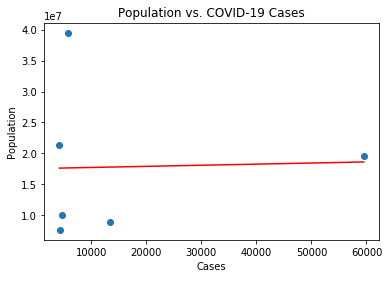

In [101]:
# look at the relationship between population and cases
## Convert to floats and store max temp and latitude as x and y values
x_values = top_states_pop['Cases'].astype('float')
y_values = top_states_pop['Population'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.title('Population vs. COVID-19 Cases')
plt.xlabel('Cases')
plt.ylabel('Population')

# Print r square value
print(f"R squard: {rvalue}")

#save plot
plt.savefig('popvcases.png')

R squard: -0.42135921306838603


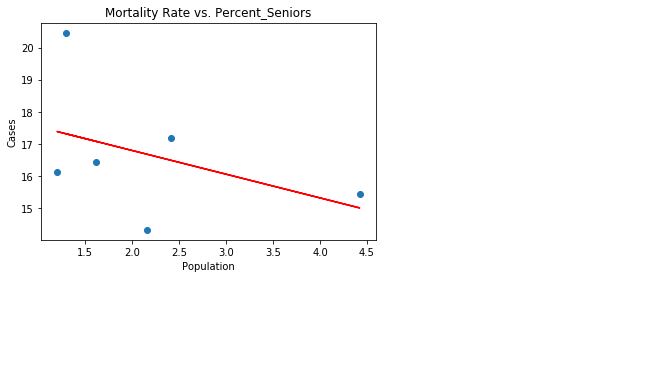

In [96]:
# look at the relationship between population and deaths
## Convert to floats and store max temp and latitude as x and y values
x_values = top_states_pop['Mortality Rate'].astype('float')
y_values = top_states_pop['Percent_Seniors'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.title('Mortality Rate vs. Percent_Seniors')
plt.xlabel('Population')
plt.ylabel('Cases')

# Print r square value
print(f"R squard: {rvalue}")

#save plot
plt.savefig('popvcases.png')

R squard: -0.15704884111330014


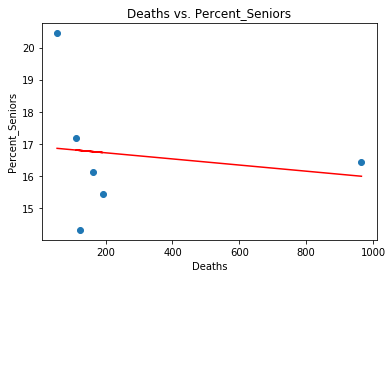

In [97]:
# look at the relationship between population and deaths
## Convert to floats and store max temp and latitude as x and y values
x_values = top_states_pop['Deaths'].astype('float')
y_values = top_states_pop['Percent_Seniors'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.title('Deaths vs. Percent_Seniors')
plt.xlabel('Deaths')
plt.ylabel('Percent_Seniors')

# Print r square value
print(f"R squard: {rvalue}")

#save plot
plt.savefig('popvcases.png')